In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

plt.style.use('ggplot')

%matplotlib inline

In [2]:
from typing import Optional, Sequence, Tuple

In [3]:
from saif.ml_utils.data_utils import daily_seismic_and_interpolated_pressure
from saif.ml_utils.pl_utils import MetricLogger
from saif.scinet.dataset import construct_time_series_dataset

from sklearn.preprocessing import MinMaxScaler

In [4]:
from darts import TimeSeries

In [5]:
import pandas as pd
seismic = pd.read_csv("../../data/02_intermediate/seismic.csv", index_col=0)
pressure = pd.read_csv("../../data/02_intermediate/pressure.csv", index_col=0)

In [6]:
features, t0, target_vals = daily_seismic_and_interpolated_pressure(seismic, pressure)
features['cum_counts'] = target_vals
len_series = len(features)
n_train = int(0.8 * len_series)

In [7]:
scaler = MinMaxScaler().fit(features[:n_train])
scaled_features = scaler.transform(features)
#scaled_features = MinMaxScaler().fit_transform(features)
scaled_features = pd.DataFrame(scaled_features, columns=features.columns)
scaled_features['index'] = np.arange(len(features))

In [8]:
number_series = TimeSeries.from_dataframe(scaled_features, 'index', 'cum_counts')
pressure_series = TimeSeries.from_dataframe(scaled_features, 'index', 'pressure')
dpdt_series = TimeSeries.from_dataframe(scaled_features, 'index', 'dpdt')

covariates = pressure_series.stack(dpdt_series)
#covariates = dpdt_series

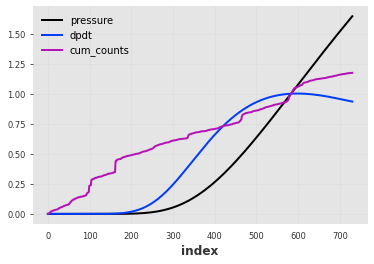

In [9]:
covariates.plot()
number_series.plot()

In [10]:
n_val = len_series - n_train

In [11]:
train, val = number_series[:n_train], number_series[n_train:]
cov_train, cov_val = covariates[:n_train], covariates[n_train:]

In [12]:
from saif.scinet.darts import SCINetModel

/home/caesar/miniconda3/envs/world/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [13]:
import torch.optim as optim

In [14]:
seed = 0 #works, run for 300
#seed = 1 #works okay, run for 150 epochs
#seed = 2 #not too well 
#seed = 10 #works, run for 300

input_len = 64
horizon = 63

#To select this, I ran n_epoch=500
#And then selected the best validation epoch
#This could have been made simpler using model checkpointing
n_epoch = 14

torch.manual_seed(seed)
np.random.seed(seed)

cb = MetricLogger()

prob_model = SCINetModel(
    input_chunk_length=input_len,
    output_chunk_length=horizon,
    dropout=0.5,
    kernel_size=5,
    hidden_size=3,
    num_levels=2,
    num_blocks=1,
    weight_norm=True,
    optimizer_kwargs={
        'lr' : 1e-3,
        'weight_decay' : 0.0001
    },
    pl_trainer_kwargs={
        'logger' : cb,
        'log_every_n_steps' : 1
    }
)

prob_model.fit(
    train, 
    past_covariates=cov_train,
    val_series=val, 
    val_past_covariates=cov_val,
    epochs=n_epoch,
    verbose=True
)


/home/caesar/miniconda3/envs/world/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/caesar/miniconda3/envs/world/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.LightningLoggerBase` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.Logger` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
/home/caesar/miniconda3/envs/world/lib/python3.9/site-packages/darts/timeseries.py:4079: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=14` reached.


In [15]:
from darts.utils.data import PastCovariatesShiftedDataset

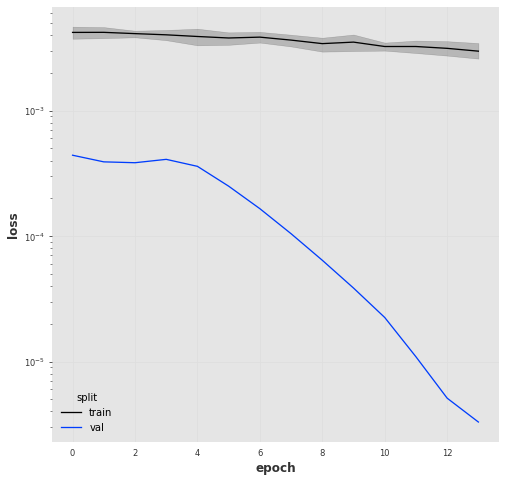

Predicting: 15it [00:00, ?it/s]

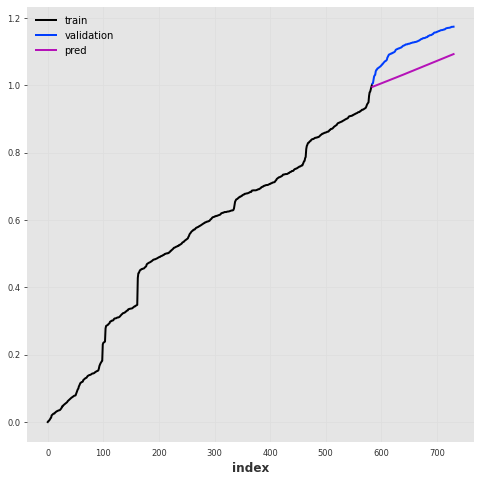

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cb.plot('loss', ax)

plt.yscale('log')
plt.show()

pred = prob_model.predict(n_val, past_covariates=covariates)

fig, axs = plt.subplots(1, 1, figsize=(8,8))
train.plot(label='train')
val.plot(label='validation', ax=axs)
pred.plot(label='pred', ax=axs)
#covariates.plot(ax=axs)
#plt.xlim(550, 750)
#plt.ylim(0.75, 1.2)

plt.show()


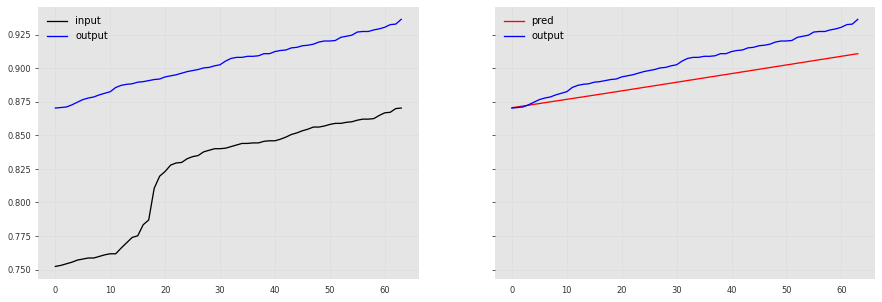

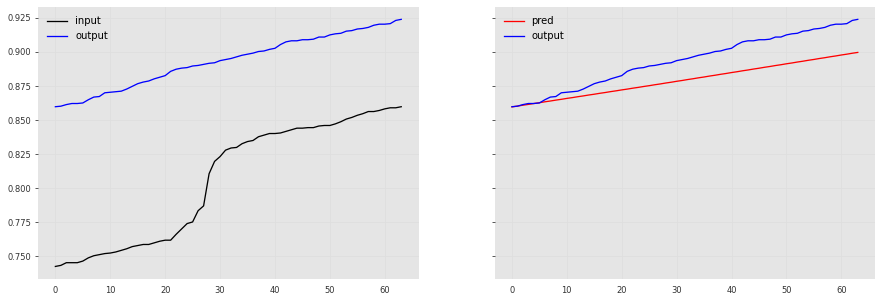

In [17]:
dset = prob_model._build_train_dataset(
    target=train, past_covariates=cov_train, 
    future_covariates=None, max_samples_per_ts=None
)

loader = DataLoader(
    dset,
    batch_size=prob_model.batch_size,
    shuffle=False,
    collate_fn=prob_model._batch_collate_fn,
)

batch = next(iter(loader))

output = prob_model.model._produce_train_output(batch[:-1])
target = batch[
    -1
]


plot_index = 10
fig, axs = plt.subplots(1,2,figsize=(15,5), sharey=True)
axs[0].plot(batch[0][plot_index].squeeze().data.numpy(), label='input')
axs[0].plot(batch[-1][plot_index].squeeze().data.numpy(), label='output', color='b')
axs[0].legend()

axs[1].plot(output[plot_index].squeeze().data.numpy(), label='pred', color='r')
axs[1].plot(batch[-1][plot_index].squeeze().data.numpy(), label='output', color='b')
axs[1].legend()

plt.show()

plot_index = 20
fig, axs = plt.subplots(1,2,figsize=(15,5), sharey=True)
axs[0].plot(batch[0][plot_index].squeeze().data.numpy(), label='input')
axs[0].plot(batch[-1][plot_index].squeeze().data.numpy(), label='output', color='b')
axs[0].legend()

axs[1].plot(output[plot_index].squeeze().data.numpy(), label='pred', color='r')
axs[1].plot(batch[-1][plot_index].squeeze().data.numpy(), label='output', color='b')
axs[1].legend()

plt.show()

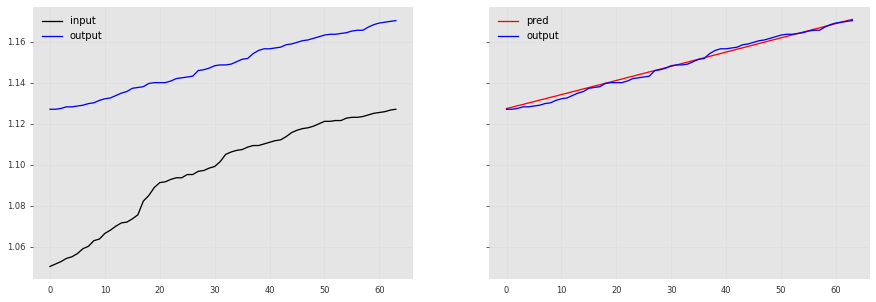

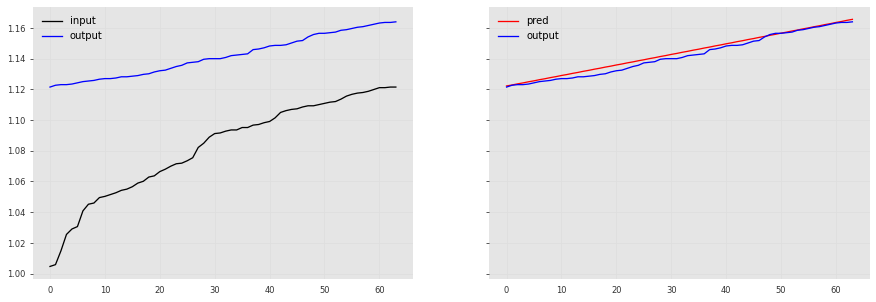

In [18]:
dset = prob_model._build_train_dataset(
    target=val, past_covariates=cov_val, 
    future_covariates=None, max_samples_per_ts=None
)

loader = DataLoader(
    dset,
    batch_size=prob_model.batch_size,
    shuffle=False,
    collate_fn=prob_model._batch_collate_fn,
)

batch = next(iter(loader))

output = prob_model.model._produce_train_output(batch[:-1])
target = batch[
    -1
]

plot_index = 10
fig, axs = plt.subplots(1,2,figsize=(15,5), sharey=True)
axs[0].plot(batch[0][plot_index].squeeze().data.numpy(), label='input')
axs[0].plot(batch[-1][plot_index].squeeze().data.numpy(), label='output', color='b')
axs[0].legend()

axs[1].plot(output[plot_index].squeeze().data.numpy(), label='pred', color='r')
axs[1].plot(batch[-1][plot_index].squeeze().data.numpy(), label='output', color='b')
axs[1].legend()

plt.show()

plot_index = 20
fig, axs = plt.subplots(1,2,figsize=(15,5), sharey=True)
axs[0].plot(batch[0][plot_index].squeeze().data.numpy(), label='input')
axs[0].plot(batch[-1][plot_index].squeeze().data.numpy(), label='output', color='b')
axs[0].legend()

axs[1].plot(output[plot_index].squeeze().data.numpy(), label='pred', color='r')
axs[1].plot(batch[-1][plot_index].squeeze().data.numpy(), label='output', color='b')
axs[1].legend()

plt.show()